In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from Attention import MutationAttention, MutationAttentionWithAdv
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import Subset



In [49]:
data = pd.read_csv("./data/train.csv")
df = data.iloc[:, 2:].copy()

# 유전자 부위를 숫자로 변환 (매핑 저장)
gene_map = {gene: idx for idx, gene in enumerate(df.columns)}

In [3]:
print(gene_map)

{'A2M': 0, 'AAAS': 1, 'AADAT': 2, 'AARS1': 3, 'ABAT': 4, 'ABCA1': 5, 'ABCA2': 6, 'ABCA3': 7, 'ABCA4': 8, 'ABCA5': 9, 'ABCA6': 10, 'ABCA8': 11, 'ABCA9': 12, 'ABCB1': 13, 'ABCB11': 14, 'ABCB4': 15, 'ABCB6': 16, 'ABCB7': 17, 'ABCB8': 18, 'ABCB9': 19, 'ABCC1': 20, 'ABCC2': 21, 'ABCC3': 22, 'ABCC4': 23, 'ABCC5': 24, 'ABCC8': 25, 'ABCD1': 26, 'ABCD2': 27, 'ABCD3': 28, 'ABCE1': 29, 'ABCF2': 30, 'ABCG2': 31, 'ABCG4': 32, 'ABCG8': 33, 'ABHD2': 34, 'ABHD4': 35, 'ABHD6': 36, 'ABI1': 37, 'ABI3BP': 38, 'ABL1': 39, 'ABLIM1': 40, 'ABR': 41, 'ACAA1': 42, 'ACAA2': 43, 'ACACA': 44, 'ACADL': 45, 'ACADM': 46, 'ACADS': 47, 'ACADSB': 48, 'ACADVL': 49, 'ACAT1': 50, 'ACAT2': 51, 'ACE': 52, 'ACHE': 53, 'ACKR1': 54, 'ACKR3': 55, 'ACLY': 56, 'ACO2': 57, 'ACOT2': 58, 'ACOT8': 59, 'ACOX1': 60, 'ACOX2': 61, 'ACOX3': 62, 'ACP1': 63, 'ACP2': 64, 'ACP5': 65, 'ACRBP': 66, 'ACRV1': 67, 'ACSL1': 68, 'ACSL3': 69, 'ACSL4': 70, 'ACSL5': 71, 'ACSL6': 72, 'ACSM1': 73, 'ACSM3': 74, 'ACSS1': 75, 'ACSS2': 76, 'ACTA1': 77, 'ACTA2

In [6]:
import numpy as np

def classify_mutation(mutation):
    if mutation == 'WT':
        return 1
    elif len(mutation) >= 2 and mutation[-1] == mutation[0]:
        return 2
    elif 'del' in mutation or 'ins' in mutation:
        return 4
    elif '*' in mutation or 'fs' in mutation:
        return 5
    else:
        return 3

encoded_samples = []
valid_indices = []
y = []

y_label = data["SUBCLASS"]  # Series

for i in range(df.shape[0]):
    sparse_row = []
    is_all_wt = True

    for j, gene in enumerate(df.columns):
        mutation = df.iloc[i, j]
        enc = classify_mutation(mutation)
        if enc != 1:
            sparse_row.append((gene, enc))
            is_all_wt = False

    if not is_all_wt:
        encoded_samples.append(sparse_row)
        valid_indices.append(i)
        y.append(y_label.iloc[i]) 



In [7]:
import torch

torch.save(encoded_samples, "data/noChangeVectorSample.pt")

In [51]:
# 1. 전체 레이블 가져오기
y_label = data["SUBCLASS"]  # pandas Series


# 3. 클래스 목록 만들고, 매핑
cancer_map = {label: idx for idx, label in enumerate(y_label.unique())}


#y_label = [cancer_map[label] for label in y]

print(cancer_map)

#y_label= np.array(y_label)



{'KIPAN': 0, 'SARC': 1, 'SKCM': 2, 'KIRC': 3, 'GBMLGG': 4, 'STES': 5, 'BRCA': 6, 'THCA': 7, 'LIHC': 8, 'HNSC': 9, 'PAAD': 10, 'OV': 11, 'PRAD': 12, 'UCEC': 13, 'LAML': 14, 'COAD': 15, 'ACC': 16, 'LGG': 17, 'LUSC': 18, 'LUAD': 19, 'CESC': 20, 'PCPG': 21, 'THYM': 22, 'BLCA': 23, 'TGCT': 24, 'DLBC': 25}


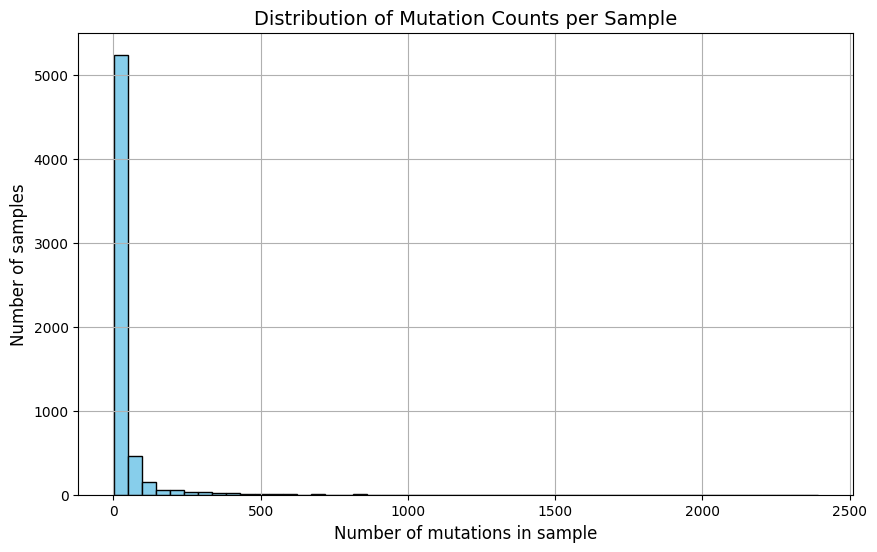

In [9]:
sample_lengths = [len(sample) for sample in encoded_samples]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sample_lengths, bins=50, color='skyblue', edgecolor='black')

plt.title("Distribution of Mutation Counts per Sample", fontsize=14)
plt.xlabel("Number of mutations in sample", fontsize=12)
plt.ylabel("Number of samples", fontsize=12)
plt.grid(True)
plt.show()

상위 5% threshold: 123.0


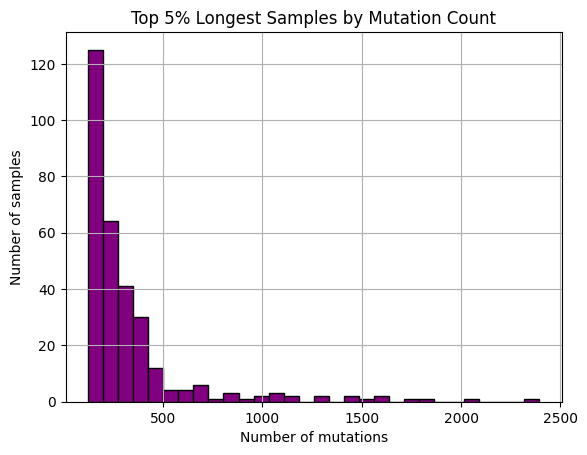

In [10]:
import numpy as np

threshold = np.percentile(sample_lengths, 95)
print(f"상위 5% threshold: {threshold}")

top_5_percent = [l for l in sample_lengths if l >= threshold]

plt.hist(top_5_percent, bins=30, color='purple', edgecolor='black')
plt.title("Top 5% Longest Samples by Mutation Count")
plt.xlabel("Number of mutations")
plt.ylabel("Number of samples")
plt.grid(True)
plt.show()

In [11]:
def preprocess_with_external_vectors(sample, gene_embeded, gene_map):
    """
    sample: List of (gene_name: str, mutation_type: int)
    gene_embeded: torch.Tensor of shape [num_genes, embedding_dim]
    gene_map: Dict[str, int] mapping gene name to index

    Returns: List of (gene_vector: torch.Tensor, mutation_type: int)
    """
    result = []

    for gene, mut_type in sample:
        idx = gene_map[gene] if gene in gene_map else 0  # fallback index
        vec = gene_embeded[idx]  # vec: Tensor[embedding_dim]
        result.append((vec, mut_type))

    return result





In [12]:
gene_embeded = np.load("data/gene_embedSVDwithWeight.npy")
gene_embeded = torch.tensor(gene_embeded)

In [13]:
train = []
for sample in encoded_samples:
    train.append(preprocess_with_external_vectors(sample, gene_embeded, gene_map))


In [14]:
import torch

torch.save(train, "data/sampleWithWeight.pt")

In [ ]:

gene_embeded = torch.tensor(gene_embeded)
y_label = torch.load("data/y_label.pt")
train = torch.load("data/sample.pt")



C:\Users\eunli\AppData\Local\Temp\ipykernel_8968\3057983561.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_label = torch.load("data/y_label.pt")
C:\Users\eunli\AppDat

In [15]:
class MutationDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]

        return sample, label



In [23]:
import random

def compute_importance(mut_type: int) -> float:
    return {
        2: 0.2,
        3: 0.5,
        4: 0.9,
        5: 1.0
    }.get(mut_type, 0.0)

def preprocess_sample_with_mixed_sampling(sample, max_len=200, top_ratio=0.6):
    vec_with_imp = [(vec, compute_importance(typ)) for vec, typ in sample]
    vec_with_imp.sort(key=lambda x: x[1], reverse=True)

    top_k = int(max_len * top_ratio)
    selected = vec_with_imp[:top_k]

    remaining = vec_with_imp[top_k:]
    remaining_sampled = random.sample(remaining, min(max_len - len(selected), len(remaining)))
    selected += remaining_sampled

    dim = vec_with_imp[0][0].shape[0] if vec_with_imp else 100
    pad_count = max_len - len(selected)

    # padding
    selected += [(torch.zeros(dim), 0.0)] * pad_count

    # mask 생성
    mask = [False] * (max_len - pad_count) + [True] * pad_count
    mask = torch.tensor(mask, dtype=torch.bool)

    q_input = [vec.float() for vec, imp in selected]
    kv_input = [vec.float() for vec, imp in selected]


    return torch.stack(q_input), torch.stack(kv_input), mask

def preprocess_sample_for_val(sample, max_len=200):
    vec_with_imp = [(vec, compute_importance(typ)) for vec, typ in sample]
    vec_with_imp.sort(key=lambda x: x[1], reverse=True)

    selected = vec_with_imp[:max_len]
    dim = selected[0][0].shape[0] if selected else 100
    pad_count = max_len - len(selected)

    selected += [(torch.zeros(dim), 0.0)] * pad_count
    mask = [False] * (max_len - pad_count) + [True] * pad_count
    mask = torch.tensor(mask, dtype=torch.bool)

    q_input = [vec.float() for vec, imp in selected]
    kv_input = [vec.float() for vec, imp in selected]

   

    return torch.stack(q_input), torch.stack(kv_input), mask



In [25]:
def collate_fn_dynamic(batch):
    q_batch, kv_batch, mask_batch, label_batch = [], [], [], []

    for sample, label in batch:
        q, kv, mask = preprocess_sample_with_mixed_sampling(sample, max_len=200)  # 여기서 랜덤 발생
        q_batch.append(q)
        kv_batch.append(kv)
        mask_batch.append(mask)
        label_batch.append(label)

    return (
        torch.stack(q_batch),
        torch.stack(kv_batch),
        torch.stack(mask_batch).bool(),   # 이게 정답
        torch.tensor(label_batch, dtype=torch.long)
    )


def collate_fn_dynamic_val(batch):
    q_batch, kv_batch, mask_batch, label_batch = [], [], [], []

    for sample, label in batch:
        q, kv, mask = preprocess_sample_for_val(sample, max_len=200)  # 여기서 랜덤 x
        q_batch.append(q)
        kv_batch.append(kv)
        mask_batch.append(mask)
        label_batch.append(label)

    return (
        torch.stack(q_batch),
        torch.stack(kv_batch),
        torch.stack(mask_batch).bool(),   # 이게 정답
        torch.tensor(label_batch, dtype=torch.long)
    )



In [26]:
from selfAttention import SelfAttention, SelfAttentionMultiHead, SelfAttentionOneHeadWithDropOut
from sklearn.utils.class_weight import compute_class_weight

# 2. 모델 & 하이퍼파라미터 세팅
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SelfAttentionMultiHead(sequence_num=200 ,d_model=150)
weights = compute_class_weight('balanced', classes=np.unique(y_label), y=y_label)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).float().to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 15
batch_size = 8


# 3. Train/Validation split (Stratified, 90/10)
indices = np.arange(len(y_label))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.1,
    stratify=y_label,
    random_state=42
)

train_subset = Subset(MutationDataset(train, y_label), train_idx)
val_subset = Subset(MutationDataset(train, y_label), val_idx)

train_loader = DataLoader(
    train_subset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn_dynamic  # epoch마다 전처리 새로 적용됨
)


val_loader = DataLoader(
    val_subset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn_dynamic_val  # epoch마다 전처리 새로 적용됨
)


# 5. 학습 루프
model.to(device)




# 4. 학습 루프
for epoch in range(epochs):
    
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for q_batch, kv_batch, mask_batch, label_batch in train_loader:
        
        q_batch = q_batch.to(device)
        kv_batch = kv_batch.to(device)
        mask_batch = mask_batch.to(device)
        label_batch = label_batch.to(device)


        output = model(q_batch, kv_batch, key_padding_mask=mask_batch)
        loss = criterion(output, label_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += (predicted == label_batch).sum().item()
        total += label_batch.size(0)

    train_acc = correct / total
    print(f"[Epoch {epoch+1}] Loss: {total_loss / len(train_loader):.4f} | Train Acc: {train_acc:.4f}")

    # 🔹 validation 평가
    model.eval()
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []


    with torch.no_grad():
        for q_batch, kv_batch, mask_batch, label_batch in val_loader:
            q_batch = q_batch.to(device)
            kv_batch = kv_batch.to(device)
            mask_batch = mask_batch.to(device)
            label_batch = label_batch.to(device)

            output = model(q_batch, kv_batch, key_padding_mask=mask_batch)
            
            _, predicted = torch.max(output, 1)

            val_correct += (predicted == label_batch).sum().item()
            val_total += label_batch.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label_batch.cpu().numpy())

    val_acc = val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'macro'
    print(f"         ✅ Val Acc: {val_acc:.4f} | Val F1-score: {val_f1:.4f}")



[Epoch 1] Loss: 2.6758 | Train Acc: 0.2209
         ✅ Val Acc: 0.2831 | Val F1-score: 0.2567
[Epoch 2] Loss: 2.1846 | Train Acc: 0.3242
         ✅ Val Acc: 0.2995 | Val F1-score: 0.2956
[Epoch 3] Loss: 2.0151 | Train Acc: 0.3497
         ✅ Val Acc: 0.3241 | Val F1-score: 0.3062
[Epoch 4] Loss: 1.9006 | Train Acc: 0.3694
         ✅ Val Acc: 0.3159 | Val F1-score: 0.3081
[Epoch 5] Loss: 1.8097 | Train Acc: 0.3852
         ✅ Val Acc: 0.3388 | Val F1-score: 0.3368
[Epoch 6] Loss: 1.7242 | Train Acc: 0.4085
         ✅ Val Acc: 0.3241 | Val F1-score: 0.3065
[Epoch 7] Loss: 1.6450 | Train Acc: 0.4258
         ✅ Val Acc: 0.3224 | Val F1-score: 0.3172
[Epoch 8] Loss: 1.5737 | Train Acc: 0.4436
         ✅ Val Acc: 0.3339 | Val F1-score: 0.3158
[Epoch 9] Loss: 1.5208 | Train Acc: 0.4496
         ✅ Val Acc: 0.3388 | Val F1-score: 0.3240
[Epoch 10] Loss: 1.4492 | Train Acc: 0.4703
         ✅ Val Acc: 0.3241 | Val F1-score: 0.3186
[Epoch 11] Loss: 1.3527 | Train Acc: 0.4934
         ✅ Val Acc: 0.329

In [ ]:
test_data = pd.read_csv("./data/test.csv")
test = data.iloc[:, 1:].copy()


test_samples = []
valid_test_indices = []
y = []

y_label = test_data["ID"]  # Series

for i in range(test_data.shape[0]):
    sparse_row = []
    is_all_wt = True

    for j, gene in enumerate(test.columns):
        mutation = test.iloc[i, j]
        enc = classify_mutation(mutation)
        if enc != 1:
            sparse_row.append((gene, enc))
            is_all_wt = False

    if not is_all_wt:
        test_samples.append(sparse_row)
        valid_test_indices.append(i)
        y.append(y_label.iloc[i]) 

In [ ]:
test_x = []

for sample in test_samples:
    test_x.append(preprocess_with_external_vectors(sample, gene_embeded, gene_map))

test_y_label = test_data["ID"]  # Series

In [43]:
def collate_fn_test(batch):
    q_batch, kv_batch, mask_batch, label_batch = [], [], [], []

    for sample, label in batch:
        q, kv, mask = preprocess_sample_for_val(sample, max_len=200)  # 여기서 랜덤 x
        q_batch.append(q)
        kv_batch.append(kv)
        mask_batch.append(mask)
        label_batch.append(label)

    return (
        torch.stack(q_batch),
        torch.stack(kv_batch),
        torch.stack(mask_batch).bool(),   # 이게 정답
        label_batch
    )

In [ ]:
test_dataset = MutationDataset(test_x, test_y_label)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn_test  # epoch마다 전처리 새로 적용됨
)

inv_cancer_map = {v: k for k, v in cancer_map.items()}

model.eval()
val_correct = 0
val_total = 0
all_preds = []
all_ids = []


with torch.no_grad():
    for q_batch, kv_batch, mask_batch, ids in test_loader:
        q_batch = q_batch.to(device)
        kv_batch = kv_batch.to(device)
        mask_batch = mask_batch.to(device)

        output = model(q_batch, kv_batch, key_padding_mask=mask_batch)
        _, predicted = torch.max(output, dim=1)

        all_ids.extend(ids)  # ids는 문자열 리스트
        all_preds.extend(predicted.cpu().numpy())  # 예측값 tensor → numpy → list



df = pd.DataFrame({
    "ID": all_ids,
    "SUBCLASS": [inv_cancer_map[pred] for pred in all_preds] # 필요하면 여기서 label name으로 매핑
})

df.to_csv("test_final.csv", index=False, encoding="utf-8-sig")